https://youtu.be/3yk9sBja7YI

Training custom models for segmentation using StarDist

In [1]:
!pip install stardist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 10.9 MB/s eta 0:00:00


In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
#matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt


from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

In [2]:
np.random.seed(42)
lbl_cmap = random_label_cmap()

In [3]:
X = list(glob('data/in1-sec.tif'))
Y = list(glob('data/in1-sec_lab.tif'))


In [4]:
import numpy as np

def slice_numpy_array_list(array_list):
    sliced_arrays = []

    for image_array in array_list:
        height, width = image_array.shape
        print(height, width)

        crop_size = 144
        stride = crop_size

        for row in range(0, height, stride):
            for col in range(0, width, stride):
                upper = row
                left = col
                lower = min(row + crop_size, height)
                right = min(col + crop_size, width)

                subarray = image_array[upper:lower, left:right]
                subarray_height, subarray_width = subarray.shape

                if subarray_height == crop_size and subarray_width == crop_size:
                    # Only append if the subarray is exactly 144x144
                    sliced_arrays.append(subarray)
                    print(f"Subarray at row {row//crop_size + 1}, column {col//crop_size + 1}: {subarray.shape}")
                else:
                    print(f"Discarding subarray at row {row//crop_size + 1}, column {col//crop_size + 1} (not 144x144)")

    return sliced_arrays


X = list(map(imread,X))
Y = list(map(imread,Y))
X = slice_numpy_array_list(X)
Y = slice_numpy_array_list(Y)

1840 1376
Subarray at row 1, column 1: (144, 144)
Subarray at row 1, column 2: (144, 144)
Subarray at row 1, column 3: (144, 144)
Subarray at row 1, column 4: (144, 144)
Subarray at row 1, column 5: (144, 144)
Subarray at row 1, column 6: (144, 144)
Subarray at row 1, column 7: (144, 144)
Subarray at row 1, column 8: (144, 144)
Subarray at row 1, column 9: (144, 144)
Discarding subarray at row 1, column 10 (not 144x144)
Subarray at row 2, column 1: (144, 144)
Subarray at row 2, column 2: (144, 144)
Subarray at row 2, column 3: (144, 144)
Subarray at row 2, column 4: (144, 144)
Subarray at row 2, column 5: (144, 144)
Subarray at row 2, column 6: (144, 144)
Subarray at row 2, column 7: (144, 144)
Subarray at row 2, column 8: (144, 144)
Subarray at row 2, column 9: (144, 144)
Discarding subarray at row 2, column 10 (not 144x144)
Subarray at row 3, column 1: (144, 144)
Subarray at row 3, column 2: (144, 144)
Subarray at row 3, column 3: (144, 144)
Subarray at row 3, column 4: (144, 144)
Su

In [5]:
X

[array([[ 0,  0,  0, ..., 12, 12, 13],
        [ 0,  0,  0, ..., 12, 14, 15],
        [ 0,  0,  0, ..., 12, 15, 13],
        ...,
        [ 0,  0,  3, ..., 12, 14, 15],
        [ 0,  0,  3, ..., 13, 16, 15],
        [ 0,  0,  3, ..., 14, 14, 16]], dtype=uint16),
 array([[11, 13, 11, ..., 13, 12, 13],
        [14, 15, 13, ..., 13, 13, 14],
        [13, 12, 13, ..., 13, 14, 13],
        ...,
        [15, 11, 13, ..., 70, 63, 68],
        [13, 12, 14, ..., 85, 78, 81],
        [14, 13, 12, ..., 94, 97, 99]], dtype=uint16),
 array([[ 13,  13,  14, ...,  14,  14,  13],
        [ 16,  13,  13, ...,  13,  12,  13],
        [ 13,  13,  14, ...,  13,  13,  14],
        ...,
        [ 71,  69,  74, ..., 187, 174, 177],
        [ 86,  87,  88, ..., 188, 182, 185],
        [101, 107, 110, ..., 199, 198, 189]], dtype=uint16),
 array([[  12,   14,   13, ...,   13,   15,   13],
        [  15,   12,   12, ...,   13,   14,   15],
        [  15,   11,   12, ...,   13,   12,   14],
        ...,
        [

In [6]:
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]  #If no third dim. then number of channels = 1. Otherwise get the num channels from the last dim.

In [7]:
#Normalize input images and fill holes in masks
axis_norm = (0,1)   # normalize channels independently
#axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 108/108 [00:00<00:00, 650.54it/s]


In [8]:
#Split to train and val
#You can use any method to split. I am following the method used in StarDist documentation example
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train]
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 108
- training:        92
- validation:      16


In [9]:
import skimage.transform
import skimage.filters
from scipy.ndimage import map_coordinates
from scipy.ndimage import gaussian_filter

def random_fliprot(img, mask):
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim)))
    mask = mask.transpose(perm)
    for ax in axes:
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    assert len(image.shape) == 2

    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x + dx, (-1,)), np.reshape(y + dy, (-1,))

    return map_coordinates(image, indices, order=1).reshape(shape)



def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)

    # Add random elastic transformation
    x = elastic_transform(x, alpha=100, sigma=10)

    sig = 0.02 * np.random.uniform(0, 1)
    x = x + sig * np.random.normal(0, 1, x.shape)

    return x, y

In [11]:
from stardist_model import Stardist
model = Stardist(32, False, (2,2))
model.CV(X_trn, Y_trn, X_val, Y_val, augmenter, [0.001], [5], [1])

base_model.py (149): output path for model already exists, files may be overwritten: C:\Users\abder\ml-project-2-segmentedsouls\models\stardist


Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.236178, nms_thresh=0.3.
Epoch 1/5
Cause: Unable to locate the source code of <function _gcd_import at 0x000001FBD28F3D80>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function _gcd_import at 0x000001FBD28F3D80>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.expe

NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:42<00:14,  2.84s/it, 0.308 -> 0.000]


Using optimized values: prob_thresh=0.307648, nms_thresh=0.3.
Saving to 'thresholds.json'.


  0%|          | 0/16 [00:00<?, ?it/s]

[{'learning_rate': 0.001,
  'epochs': 5,
  'steps_per_epoch': 1,
  'stats': [DatasetMatching(criterion='iou', thresh=0.1, fp=2886, tp=11, fn=199, precision=0.0037970314118053157, recall=0.05238095238095238, accuracy=0.0035529715762273903, f1=0.007080785323463148, n_true=210, n_pred=2897, mean_true_score=0.013106576140437807, mean_matched_score=0.2502164535901763, panoptic_quality=0.0017717289922703184, by_image=False),
   DatasetMatching(criterion='iou', thresh=0.2, fp=3107, tp=0, fn=139, precision=0, recall=0, accuracy=0, f1=0, n_true=139, n_pred=3107, mean_true_score=0.0, mean_matched_score=0.0, panoptic_quality=0.0, by_image=False),
   DatasetMatching(criterion='iou', thresh=0.3, fp=4518, tp=0, fn=14, precision=0, recall=0, accuracy=0, f1=0, n_true=14, n_pred=4518, mean_true_score=0.0, mean_matched_score=0.0, panoptic_quality=0.0, by_image=False),
   DatasetMatching(criterion='iou', thresh=0.4, fp=2719, tp=0, fn=143, precision=0, recall=0, accuracy=0, f1=0, n_true=143, n_pred=2719, 

In [12]:
model.scores

[{'learning_rate': 0.001,
  'epochs': 5,
  'steps_per_epoch': 1,
  'stats': [DatasetMatching(criterion='iou', thresh=0.1, fp=2886, tp=11, fn=199, precision=0.0037970314118053157, recall=0.05238095238095238, accuracy=0.0035529715762273903, f1=0.007080785323463148, n_true=210, n_pred=2897, mean_true_score=0.013106576140437807, mean_matched_score=0.2502164535901763, panoptic_quality=0.0017717289922703184, by_image=False),
   DatasetMatching(criterion='iou', thresh=0.2, fp=3107, tp=0, fn=139, precision=0, recall=0, accuracy=0, f1=0, n_true=139, n_pred=3107, mean_true_score=0.0, mean_matched_score=0.0, panoptic_quality=0.0, by_image=False),
   DatasetMatching(criterion='iou', thresh=0.3, fp=4518, tp=0, fn=14, precision=0, recall=0, accuracy=0, f1=0, n_true=14, n_pred=4518, mean_true_score=0.0, mean_matched_score=0.0, panoptic_quality=0.0, by_image=False),
   DatasetMatching(criterion='iou', thresh=0.4, fp=2719, tp=0, fn=143, precision=0, recall=0, accuracy=0, f1=0, n_true=143, n_pred=2719, 

In [72]:
#PLot image and label for some images - sanity check
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()


i = min(9, len(X)-1)
"""
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
for index, x in enumerate(X):
    plot_img_label(X[index], Y[index])"""


'\nimg, lbl = X[i], Y[i]\nassert img.ndim in (2,3)\nimg = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]\nfor index, x in enumerate(X):\n    plot_img_label(X[index], Y[index])'

In [73]:
#Check config to get an idea about all parameters
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

In [74]:
#Define the config by setting some parameter values

# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32  #Number of radial directions for the star-convex polygon.

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
    train_patch_size = (144, 144)
)
print(conf)
vars(conf)

Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(144, 144), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, 

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (144, 144),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


In [41]:
conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = True,
    n_channel_in = n_channel,
    train_patch_size = (144, 144),
    train_learning_rate       = 0.003
)
conf

Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(144, 144), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.003, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, u

In [44]:
use_gpu = True
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    limit_gpu_memory(0.8)


ValueError: ignored

10/10 [==============================] - 1s 157ms/step - loss: 1.8631 - prob_loss: 0.4111 - dist_loss: 7.2597 - prob_kld: 0.2577 - dist_relevant_mae: 7.2595 - dist_relevant_mse: 90.6839 - dist_dist_iou_metric: 0.0594 - val_loss: 1.5350 - val_prob_loss: 0.3660 - val_dist_loss: 5.8453 - val_prob_kld: 0.2279 - val_dist_relevant_mae: 5.8450 - val_dist_relevant_mse: 61.4902 - val_dist_dist_iou_metric: 0.1365 - lr: 0.1000
Epoch 3/10
10/10 [==============================] - 1s 123ms/step - loss: 7389.2798 - prob_loss: 7388.0171 - dist_loss: 6.3153 - prob_kld: 0.1983 - dist_relevant_mae: 5.2172 - dist_relevant_mse: 50.4030 - dist_dist_iou_metric: 0.2024 - val_loss: 1.2920 - val_prob_loss: 0.3150 - val_dist_loss: 4.8852 - val_prob_kld: 0.1769 - val_dist_relevant_mae: 4.8847 - val_dist_relevant_mse: 42.9465 - val_dist_dist_iou_metric: 0.2698 - lr: 0.1000
Epoch 4/10
10/10 [==============================] - 1s 67ms/step - loss: 1.4190 - prob_loss: 0.4232 - dist_loss: 4.9792 - prob_kld: 0.2605 - di

NMS threshold = 0.5:  70%|███████   | 14/20 [00:24<00:10,  1.78s/it, 0.088 -> 0.000]


Using optimized values: prob_thresh=0.0873586, nms_thresh=0.3.
Saving to 'thresholds.json'.


100%|██████████| 9/9 [00:00<00:00, 15.20it/s]


Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.0873586, nms_thresh=0.3.
Epoch 1/10
10/10 [==============================] - 7s 168ms/step - loss: 3.7942 - prob_loss: 1.4308 - dist_loss: 11.8168 - prob_kld: 0.5549 - dist_relevant_mae: 11.8164 - dist_relevant_mse: 332.4736 - dist_dist_iou_metric: 0.0167 - val_loss: 2.3147 - val_prob_loss: 0.5569 - val_dist_loss: 8.7893 - val_prob_kld: 0.4188 - val_dist_relevant_mae: 8.7893 - val_dist_relevant_mse: 114.1311 - val_dist_dist_iou_metric: 4.6515e-04 - lr: 0.0100
Epoch 2/10
10/10 [==============================] - 1s 96ms/step - loss: 2.3037 - prob_loss: 0.5281 - dist_loss: 8.8781 - prob_kld: 0.3705 - dist_relevant_mae: 8.8781 - dist_relevant_mse: 116.5534 - dist_dist_iou_metric: 6.3894e-04 - val_loss: 2.2161 - val_prob_loss: 0.4691 - val_dist_loss: 8.7347 - val_prob_kld: 0.3310 - val_dist_relevant_mae: 8.7347 - val_dist_relevant_mse: 113.1762 - val_dist_dist_iou_metric: 9.6365e-04 - lr: 0.0100
Epoch 3/10
10/10 

NMS threshold = 0.5:  70%|███████   | 14/20 [00:45<00:19,  3.25s/it, 0.085 -> 0.000]


Using optimized values: prob_thresh=0.0844423, nms_thresh=0.5.
Saving to 'thresholds.json'.


100%|██████████| 9/9 [00:00<00:00, 13.51it/s]


Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.0844423, nms_thresh=0.5.
Epoch 1/10
10/10 [==============================] - 8s 323ms/step - loss: 2.3258 - prob_loss: 0.5399 - dist_loss: 8.9292 - prob_kld: 0.3780 - dist_relevant_mae: 8.9292 - dist_relevant_mse: 117.7774 - dist_dist_iou_metric: 0.0068 - val_loss: 1.9541 - val_prob_loss: 0.4091 - val_dist_loss: 7.7252 - val_prob_kld: 0.2710 - val_dist_relevant_mae: 7.7251 - val_dist_relevant_mse: 94.3947 - val_dist_dist_iou_metric: 0.0258 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - 1s 133ms/step - loss: 1.8004 - prob_loss: 0.4200 - dist_loss: 6.9018 - prob_kld: 0.2734 - dist_relevant_mae: 6.9015 - dist_relevant_mse: 81.1109 - dist_dist_iou_metric: 0.1027 - val_loss: 1.4066 - val_prob_loss: 0.3411 - val_dist_loss: 5.3275 - val_prob_kld: 0.2030 - val_dist_relevant_mae: 5.3270 - val_dist_relevant_mse: 50.8602 - val_dist_dist_iou_metric: 0.2304 - lr: 0.0010
Epoch 3/10
10/10 [===============

NMS threshold = 0.5:  15%|█▌        | 3/20 [00:00<00:00, 32.03it/s, 0.271 -> 0.000]


Using optimized values: prob_thresh=0.135531, nms_thresh=0.3.
Saving to 'thresholds.json'.


100%|██████████| 9/9 [00:00<00:00, 16.72it/s]


Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.135531, nms_thresh=0.3.
Epoch 1/10
10/10 [==============================] - 8s 237ms/step - loss: 2.4830 - prob_loss: 0.6886 - dist_loss: 8.9718 - prob_kld: 0.5292 - dist_relevant_mae: 8.9718 - dist_relevant_mse: 118.1578 - dist_dist_iou_metric: 5.1585e-07 - val_loss: 2.4636 - val_prob_loss: 0.6837 - val_dist_loss: 8.8992 - val_prob_kld: 0.5457 - val_dist_relevant_mae: 8.8992 - val_dist_relevant_mse: 115.5406 - val_dist_dist_iou_metric: 5.4213e-07 - lr: 1.0000e-04
Epoch 2/10
10/10 [==============================] - 1s 102ms/step - loss: 2.4322 - prob_loss: 0.6595 - dist_loss: 8.8634 - prob_kld: 0.5179 - dist_relevant_mae: 8.8634 - dist_relevant_mse: 116.0030 - dist_dist_iou_metric: 4.9942e-06 - val_loss: 2.4051 - val_prob_loss: 0.6247 - val_dist_loss: 8.9018 - val_prob_kld: 0.4866 - val_dist_relevant_mae: 8.9018 - val_dist_relevant_mse: 115.5919 - val_dist_dist_iou_metric: 1.1818e-05 - lr: 1.0000e-04
Epoch 3

NMS threshold = 0.5:  15%|█▌        | 3/20 [00:00<00:00, 31.83it/s, 0.378 -> 0.000]


Using optimized values: prob_thresh=0.189102, nms_thresh=0.3.
Saving to 'thresholds.json'.


100%|██████████| 9/9 [00:00<00:00, 17.18it/s]


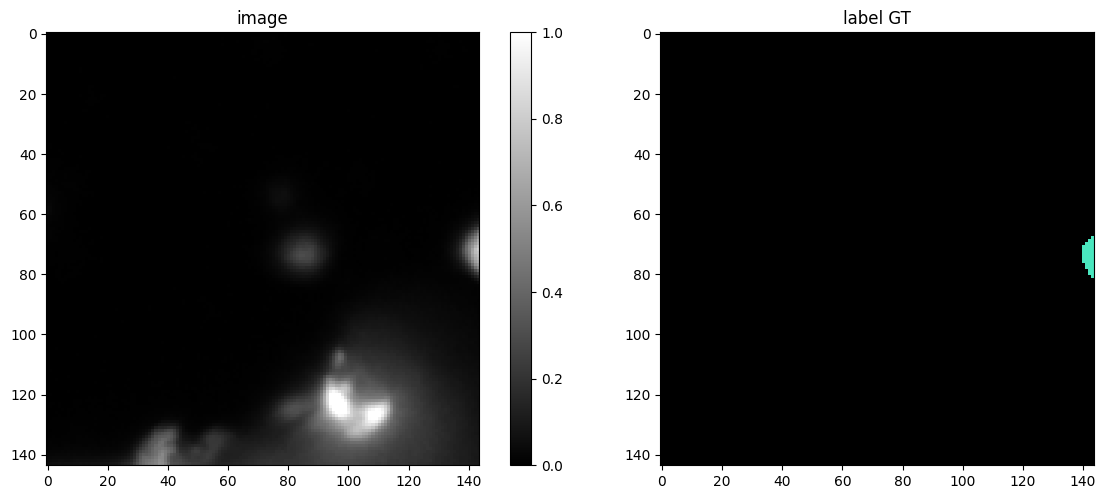

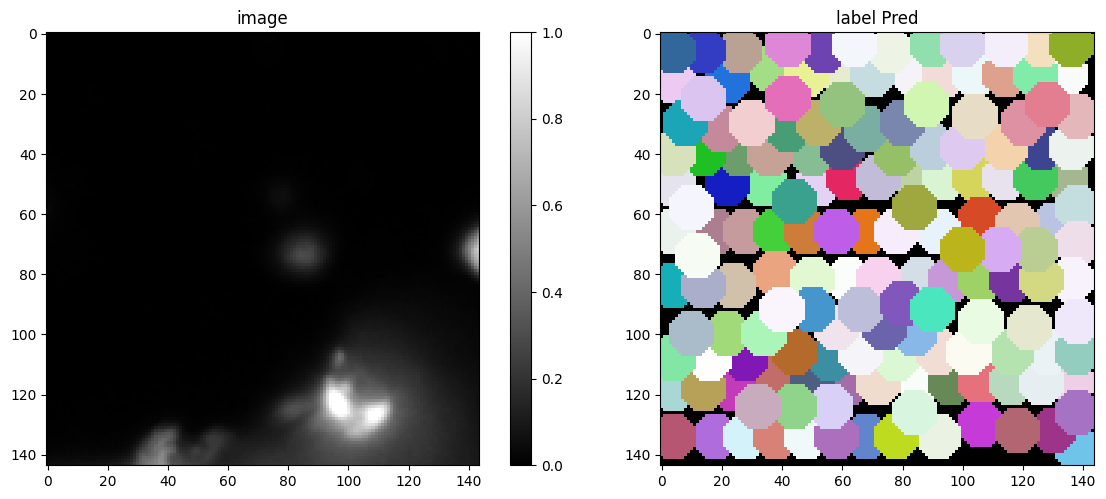

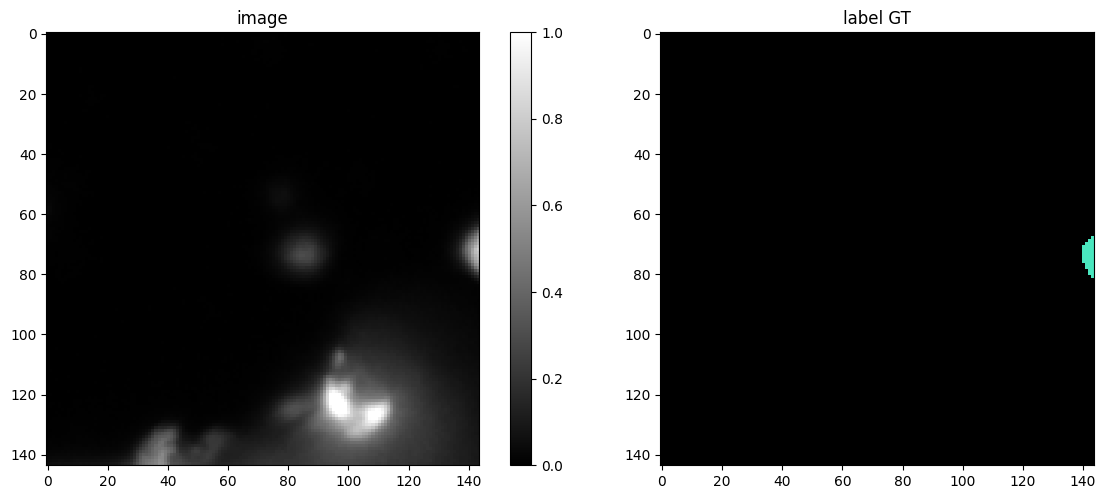

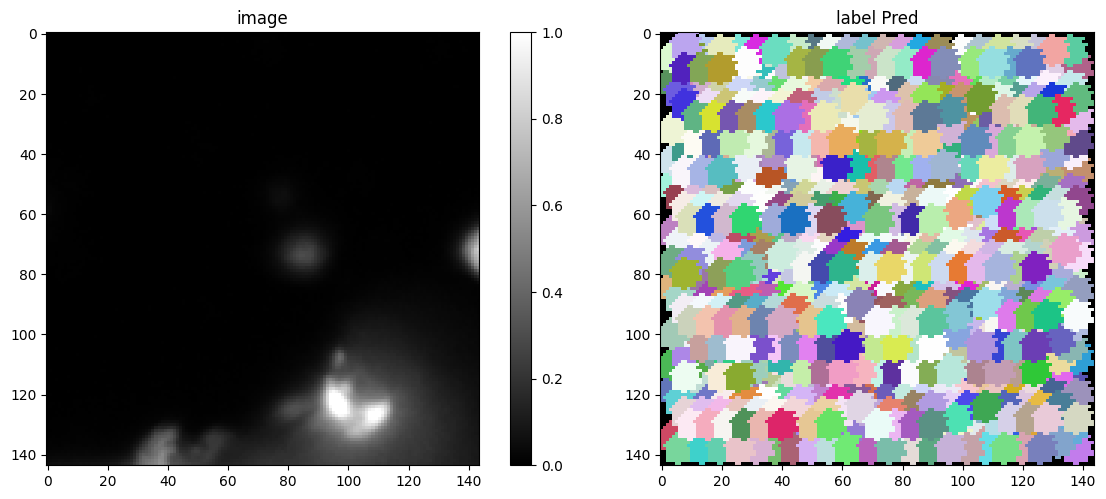

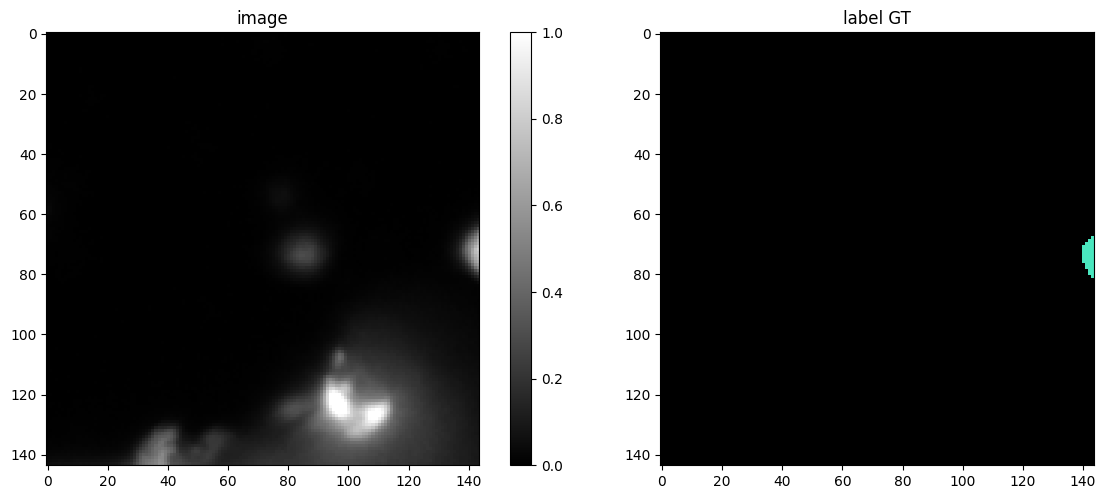

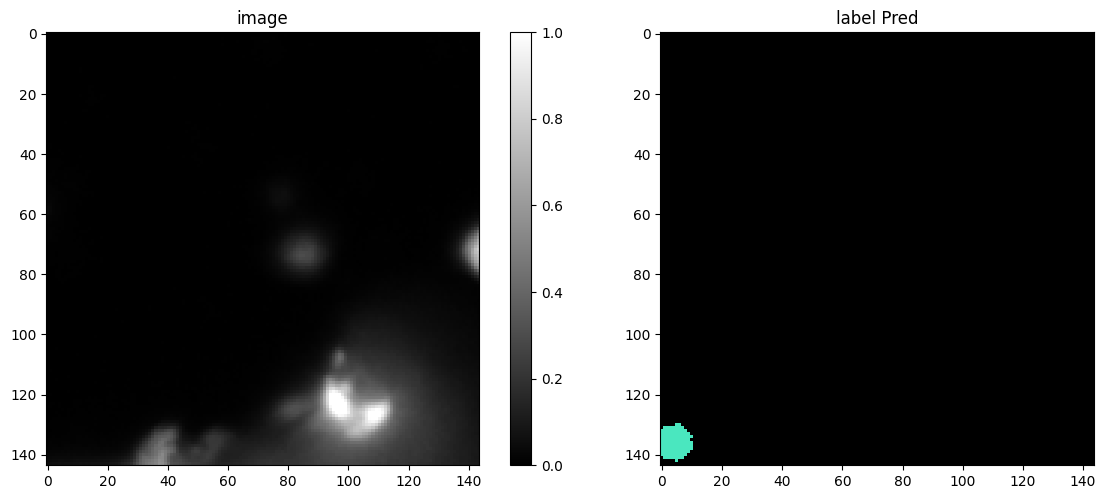

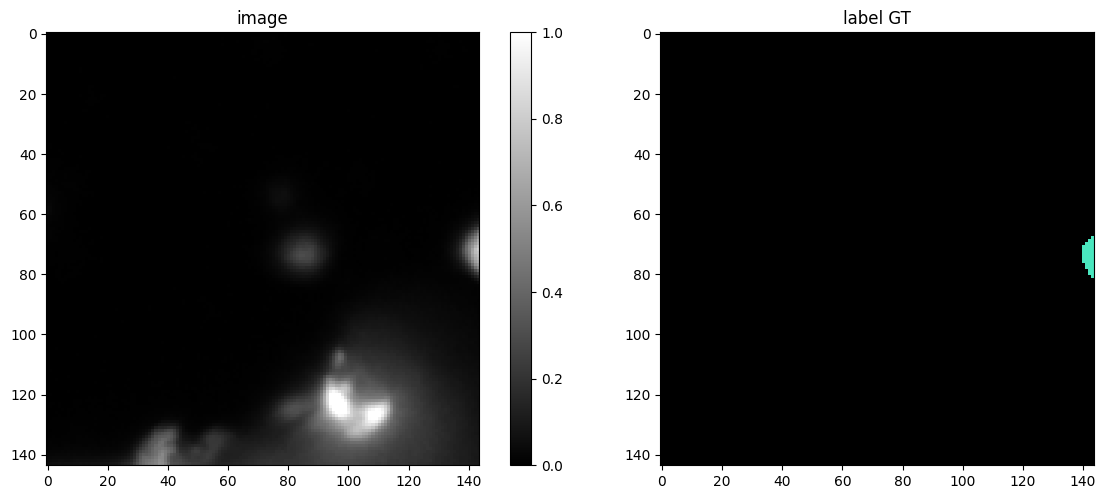

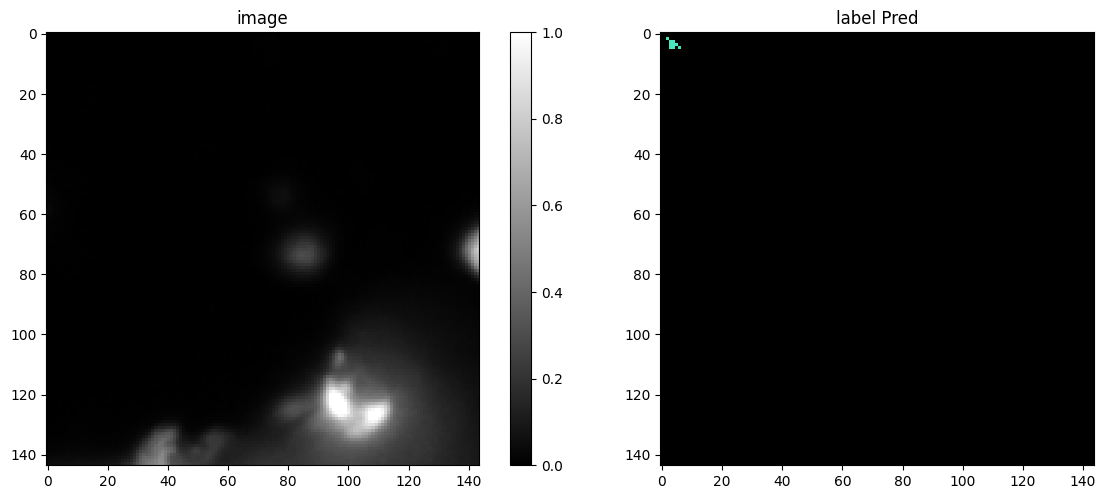

In [64]:
print(f1_score)
print(f1_score[0].f1,f1_score[1].f1, f1_score[2].f1, f1_score[3].f1)

[DatasetMatching(criterion='iou', thresh=0.5, fp=2031, tp=39, fn=171, precision=0.01884057971014493, recall=0.18571428571428572, accuracy=0.01740294511378849, f1=0.034210526315789476, n_true=210, n_pred=2070, mean_true_score=0.11926405060858954, mean_matched_score=0.642191041738559, panoptic_quality=0.02196969353316123, by_image=False), DatasetMatching(criterion='iou', thresh=0.5, fp=3857, tp=33, fn=177, precision=0.008483290488431876, recall=0.15714285714285714, accuracy=0.008114089009097615, f1=0.016097560975609757, n_true=210, n_pred=3890, mean_true_score=0.09163347511064439, mean_matched_score=0.5831221143404642, panoptic_quality=0.009386843791822108, by_image=False), DatasetMatching(criterion='iou', thresh=0.5, fp=13, tp=0, fn=210, precision=0, recall=0, accuracy=0, f1=0, n_true=210, n_pred=13, mean_true_score=0.0, mean_matched_score=0.0, panoptic_quality=0.0, by_image=False), DatasetMatching(criterion='iou', thresh=0.5, fp=4, tp=0, fn=210, precision=0, recall=0, accuracy=0, f1=0,

In [14]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")


median object size:      [121. 119.]
network field of view :  [91 92]


In [75]:
pip install elasticdeform


In [76]:
import skimage.transform
import skimage.filters
from scipy.ndimage import map_coordinates
from scipy.ndimage import gaussian_filter

def random_fliprot(img, mask):
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim)))
    mask = mask.transpose(perm)
    for ax in axes:
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    assert len(image.shape) == 2

    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x + dx, (-1,)), np.reshape(y + dy, (-1,))

    return map_coordinates(image, indices, order=1).reshape(shape)



def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)

    # Add random elastic transformation
    x = elastic_transform(x, alpha=100, sigma=10)

    sig = 0.02 * np.random.uniform(0, 1)
    x = x + sig * np.random.normal(0, 1, x.shape)

    return x, y

In [ ]:

# plot some augmented examples
img, lbl = X[3],Y[3]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")


base_model.py (149): output path for model already exists, files may be overwritten: /content/drive/MyDrive/Colab Notebooks/models/stardist_tutorial


Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.189102, nms_thresh=0.3.
Epoch 1/10
10/10 [==============================] - 18s 522ms/step - loss: 674678177792.0000 - prob_loss: 407862214656.0000 - dist_loss: 1334079782912.0000 - prob_kld: 0.6983 - dist_relevant_mae: 1333991178240.0000 - dist_relevant_mse: 22626162926571685169594368.0000 - dist_dist_iou_metric: 0.0017 - val_loss: 2.1397 - val_prob_loss: 0.5178 - val_dist_loss: 8.1092 - val_prob_kld: 0.3797 - val_dist_relevant_mae: 8.1091 - val_dist_relevant_mse: 101.4204 - val_dist_dist_iou_metric: 0.0091 - lr: 0.1000
Epoch 2/10
10/10 [==============================] - 2s 213ms/step - loss: 2.0333 - prob_loss: 0.4492 - dist_loss: 7.9203 - prob_kld: 0.2977 - dist_relevant_mae: 7.9202 - dist_relevant_mse: 100.1896 - dist_dist_iou_metric: 0.0233 - val_loss: 1.7864 - val_prob_loss: 0.3666 - val_dist_loss: 7.0991 - val_prob_kld: 0.2285 - val_dist_relevant_mae: 7.0989 - val_dist_relevant_mse: 83.8463 - val_dist

NMS threshold = 0.5:  70%|███████   | 14/20 [00:36<00:15,  2.62s/it, 0.091 -> 0.000]


Using optimized values: prob_thresh=0.0908738, nms_thresh=0.3.
Saving to 'thresholds.json'.


100%|██████████| 9/9 [00:01<00:00,  6.30it/s]


Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.0908738, nms_thresh=0.3.
Epoch 1/10
10/10 [==============================] - 7s 170ms/step - loss: 2.5115 - prob_loss: 0.8348 - dist_loss: 8.3837 - prob_kld: 0.5745 - dist_relevant_mae: 8.3836 - dist_relevant_mse: 106.5623 - dist_dist_iou_metric: 0.0214 - val_loss: 2.1852 - val_prob_loss: 0.5076 - val_dist_loss: 8.3879 - val_prob_kld: 0.3696 - val_dist_relevant_mae: 8.3878 - val_dist_relevant_mse: 107.4064 - val_dist_dist_iou_metric: 0.0048 - lr: 0.0100
Epoch 2/10
10/10 [==============================] - 1s 100ms/step - loss: 2.0369 - prob_loss: 0.5103 - dist_loss: 7.6330 - prob_kld: 0.3389 - dist_relevant_mae: 7.6327 - dist_relevant_mse: 105.1951 - dist_dist_iou_metric: 0.1234 - val_loss: 1.5336 - val_prob_loss: 0.3088 - val_dist_loss: 6.1237 - val_prob_kld: 0.1708 - val_dist_relevant_mae: 6.1234 - val_dist_relevant_mse: 67.7067 - val_dist_dist_iou_metric: 0.1141 - lr: 0.0100
Epoch 3/10
10/10 [=============

NMS threshold = 0.5:  15%|█▌        | 3/20 [00:00<00:00, 22.60it/s, 0.258 -> 0.000]


Using optimized values: prob_thresh=0.129044, nms_thresh=0.3.
Saving to 'thresholds.json'.


100%|██████████| 9/9 [00:00<00:00, 16.83it/s]


Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.129044, nms_thresh=0.3.
Epoch 1/10
10/10 [==============================] - 7s 203ms/step - loss: 2.5038 - prob_loss: 0.7140 - dist_loss: 8.9492 - prob_kld: 0.4986 - dist_relevant_mae: 8.9491 - dist_relevant_mse: 120.6934 - dist_dist_iou_metric: 0.0079 - val_loss: 2.3545 - val_prob_loss: 0.6189 - val_dist_loss: 8.6781 - val_prob_kld: 0.4808 - val_dist_relevant_mae: 8.6781 - val_dist_relevant_mse: 110.6662 - val_dist_dist_iou_metric: 9.9698e-05 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - 1s 131ms/step - loss: 2.2175 - prob_loss: 0.4903 - dist_loss: 8.6360 - prob_kld: 0.3433 - dist_relevant_mae: 8.6360 - dist_relevant_mse: 111.0867 - dist_dist_iou_metric: 0.0068 - val_loss: 1.9448 - val_prob_loss: 0.3803 - val_dist_loss: 7.8226 - val_prob_kld: 0.2422 - val_dist_relevant_mae: 7.8225 - val_dist_relevant_mse: 95.5366 - val_dist_dist_iou_metric: 0.0175 - lr: 0.0010
Epoch 3/10
10/10 [==========

NMS threshold = 0.5:  15%|█▌        | 3/20 [00:00<00:01, 14.92it/s, 0.294 -> 0.000]


Using optimized values: prob_thresh=0.146976, nms_thresh=0.3.
Saving to 'thresholds.json'.


100%|██████████| 9/9 [00:00<00:00, 15.82it/s]


Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.146976, nms_thresh=0.3.
Epoch 1/10
10/10 [==============================] - 7s 179ms/step - loss: 2.4577 - prob_loss: 0.6743 - dist_loss: 8.9170 - prob_kld: 0.5079 - dist_relevant_mae: 8.9170 - dist_relevant_mse: 116.8247 - dist_dist_iou_metric: 7.2323e-06 - val_loss: 2.4117 - val_prob_loss: 0.6528 - val_dist_loss: 8.7941 - val_prob_kld: 0.5148 - val_dist_relevant_mae: 8.7941 - val_dist_relevant_mse: 112.9660 - val_dist_dist_iou_metric: 1.5392e-05 - lr: 1.0000e-04
Epoch 2/10
10/10 [==============================] - 1s 145ms/step - loss: 2.2840 - prob_loss: 0.5128 - dist_loss: 8.8564 - prob_kld: 0.3835 - dist_relevant_mae: 8.8564 - dist_relevant_mse: 117.3430 - dist_dist_iou_metric: 6.3599e-04 - val_loss: 2.1664 - val_prob_loss: 0.4103 - val_dist_loss: 8.7807 - val_prob_kld: 0.2722 - val_dist_relevant_mae: 8.7806 - val_dist_relevant_mse: 113.0547 - val_dist_dist_iou_metric: 0.0021 - lr: 1.0000e-04
Epoch 3/10


NMS threshold = 0.5:  75%|███████▌  | 15/20 [01:42<00:34,  6.86s/it, 0.254 -> 0.000]


Using optimized values: prob_thresh=0.280757, nms_thresh=0.3.
Saving to 'thresholds.json'.


100%|██████████| 9/9 [00:00<00:00, 15.31it/s]


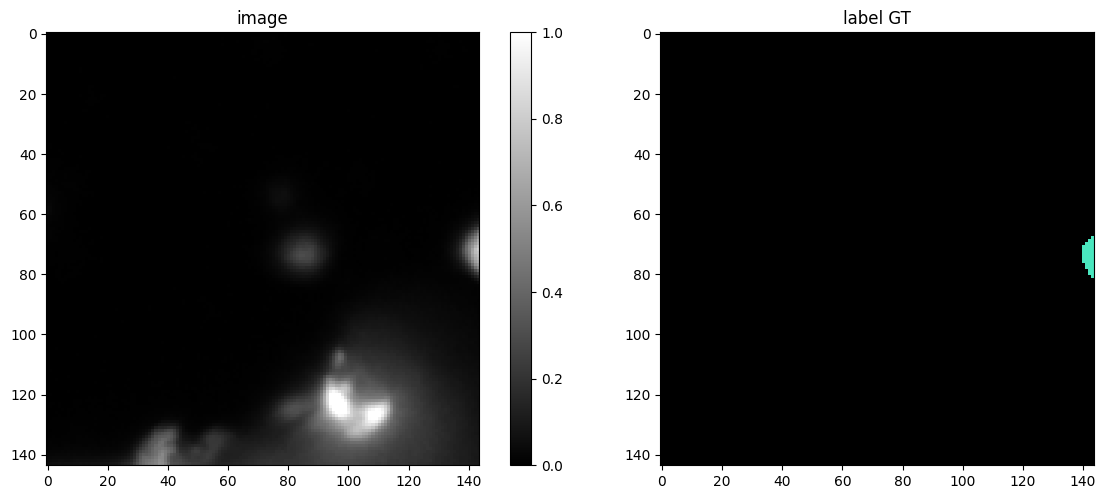

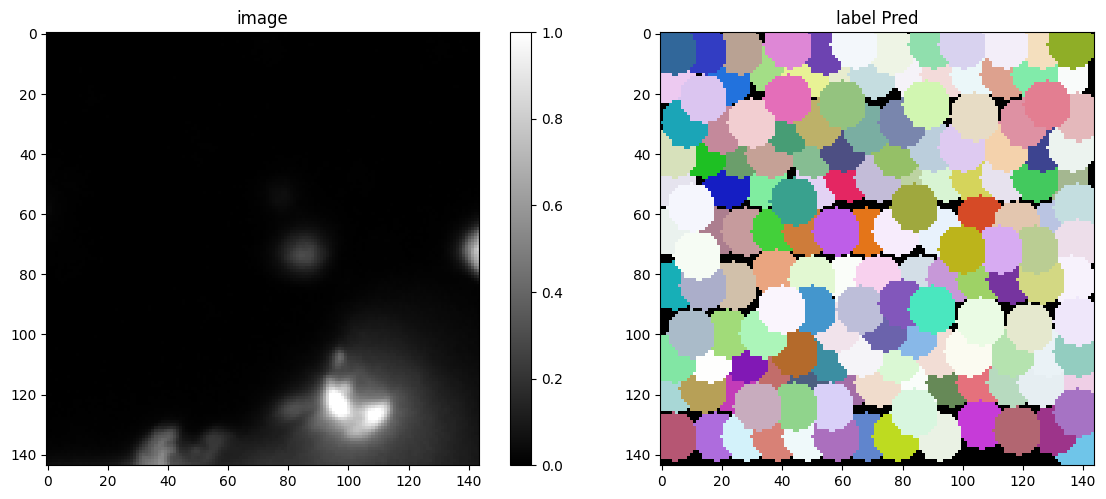

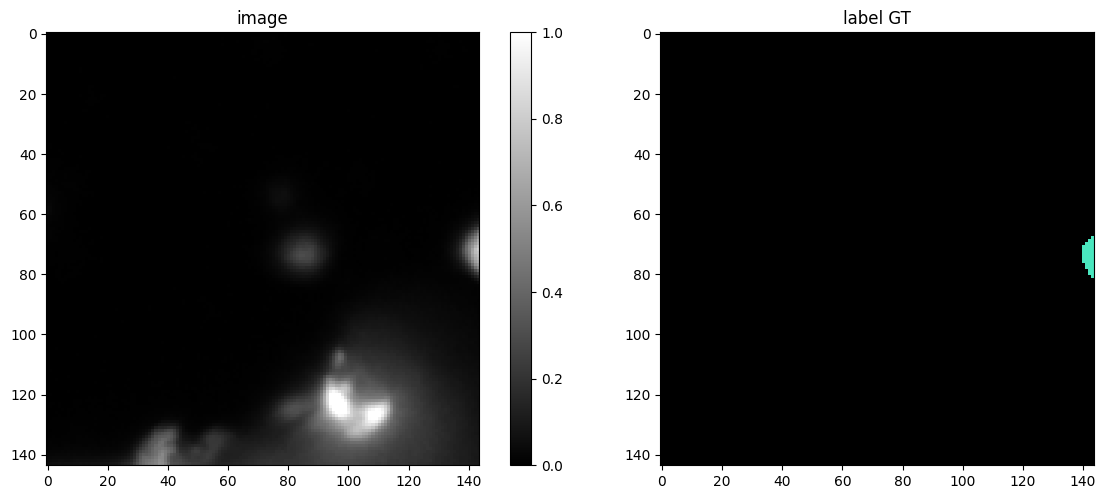

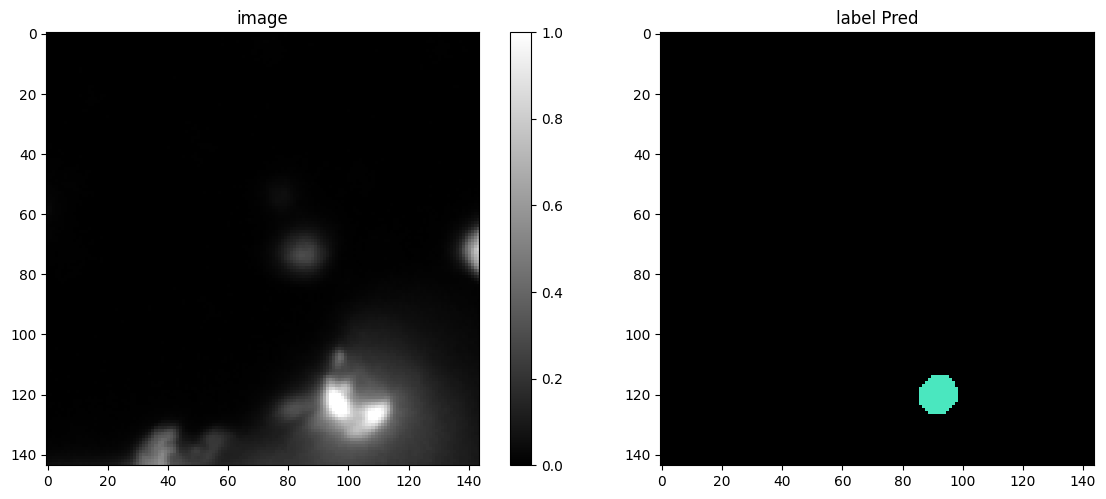

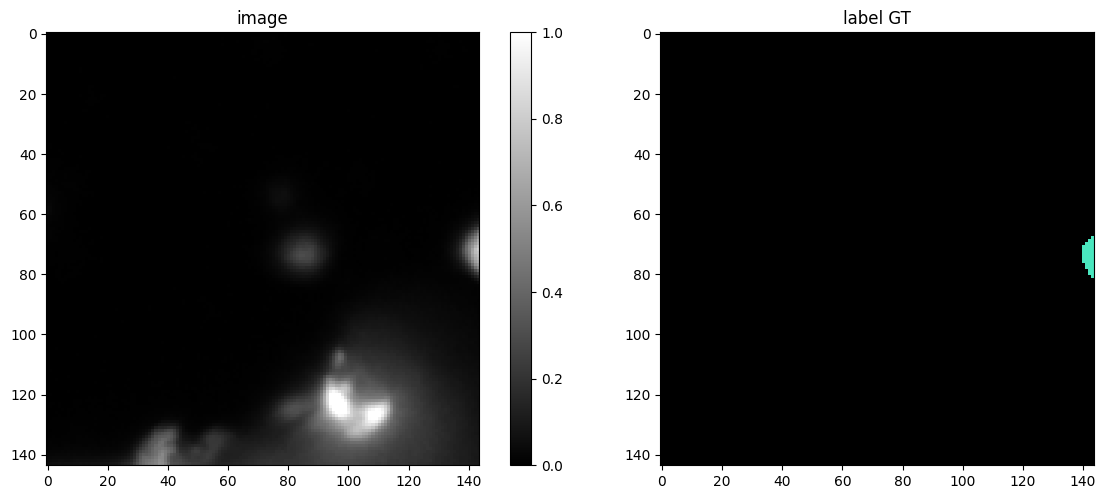

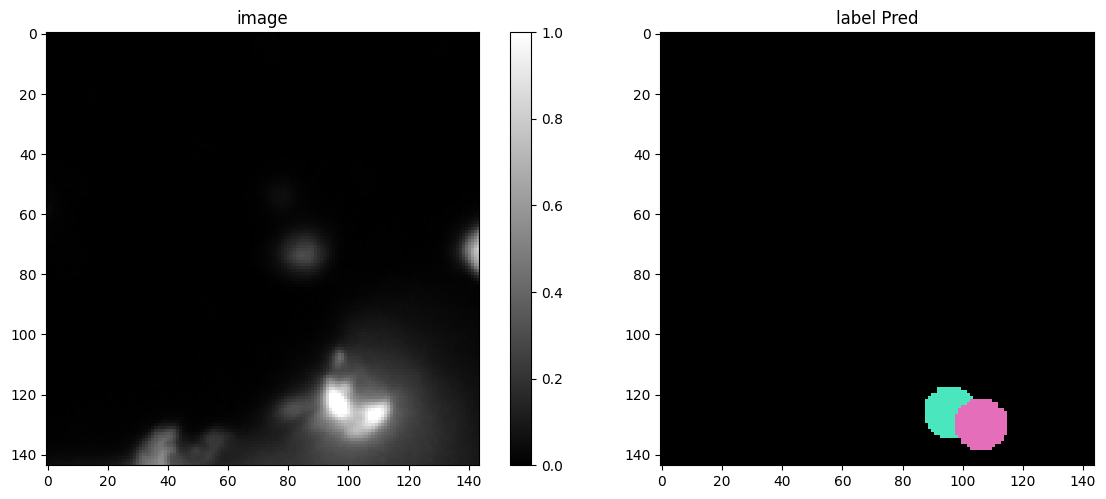

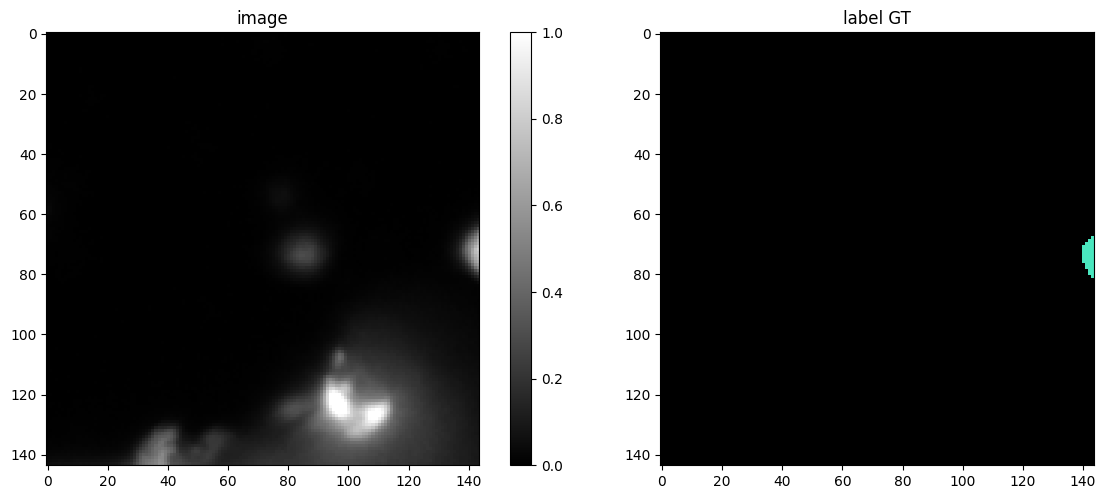

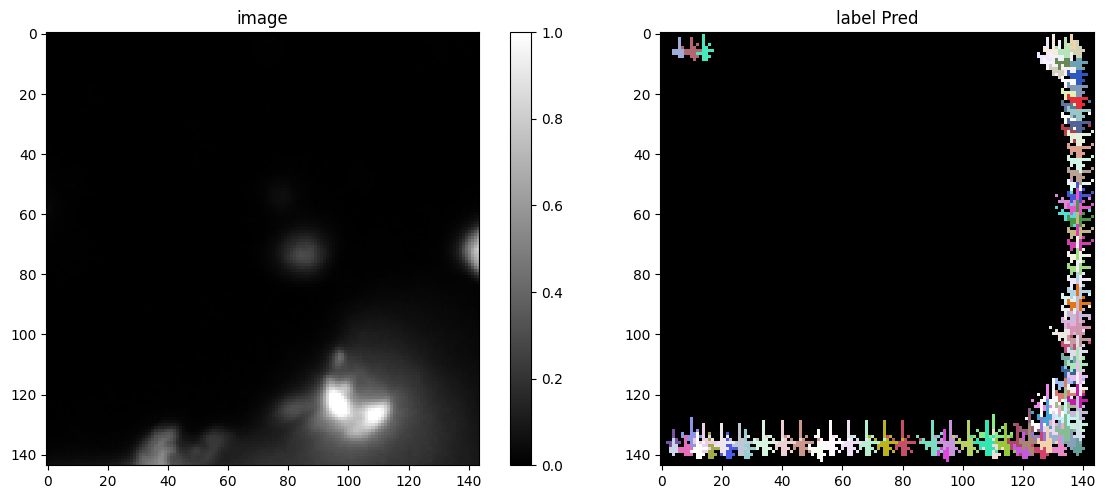

In [77]:
f1_score = list()
for learning_rate in [0.1, 0.01, 0.001, 0.0001]:
    conf = Config2D (
        n_rays       = n_rays,
        grid         = grid,
        use_gpu      = False,
        n_channel_in = n_channel,
        train_patch_size = (144, 144),
        train_learning_rate       = learning_rate
    )
    model = StarDist2D(conf, name='stardist_tutorial', basedir='/content/drive/MyDrive/Colab Notebooks/models')
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter, epochs=10, steps_per_epoch=10)

    model.optimize_thresholds(X_val, Y_val)
    Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
                  for x in tqdm(X_val)]


    taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    stats = [matching_dataset(Y_val[0], Y_val_pred[0], thresh=t, show_progress=False) for t in tqdm(taus)]

    stats[taus.index(0.5)]
    f1_score.append(stats[4])

In [79]:
print(f1_score[0].f1,f1_score[1].f1, f1_score[2].f1, f1_score[3].f1)

0.035640281806879406 0.0321285140562249 0.06 0.002183406113537118


In [ ]:
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter, epochs=1000, steps_per_epoch=10)

In [28]:
#Optimize the thresolds using the trained model
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:01<00:00,  8.10it/s, 0.463 -> 0.014]


Using optimized values: prob_thresh=0.462658, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.462657587113259, 'nms': 0.3}

In [29]:
#Load saved model
my_model = StarDist2D(None, name='stardist_tutorial', basedir='/content/drive/MyDrive/Colab Notebooks/models')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.462658, nms_thresh=0.3.


In [30]:
model=my_model

In [31]:
#Predict on validation images
model.optimize_thresholds(X_val, Y_val)
X_val2 = list(X_val[0])
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

#PLot original labels and predcitions
plot_img_label(X_val[2],Y_val[2], lbl_title="label GT")
plot_img_label(X_val[2],Y_val_pred[2], lbl_title="label Pred")


taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val[0], Y_val_pred[0], thresh=t, show_progress=False) for t in tqdm(taus)]

stats[taus.index(0.5)]

100%|██████████| 16/16 [00:01<00:00, 14.29it/s]


100%|██████████| 9/9 [00:00<00:00, 15.52it/s]


DatasetMatching(criterion='iou', thresh=0.5, fp=142, tp=62, fn=148, precision=0.30392156862745096, recall=0.29523809523809524, accuracy=0.17613636363636365, f1=0.2995169082125604, n_true=210, n_pred=204, mean_true_score=0.2180867734409514, mean_matched_score=0.7386810068161257, panoptic_quality=0.2212474513169072, by_image=False)

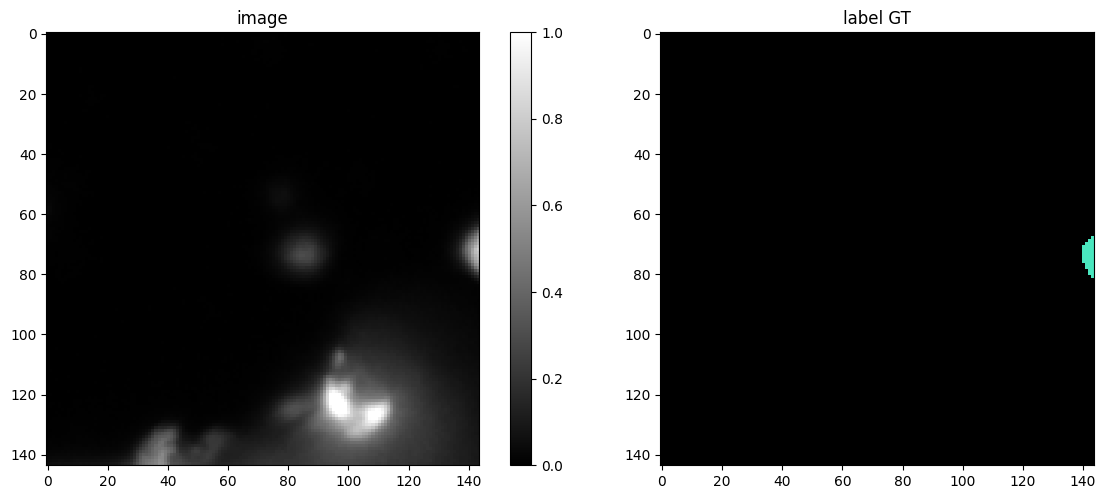

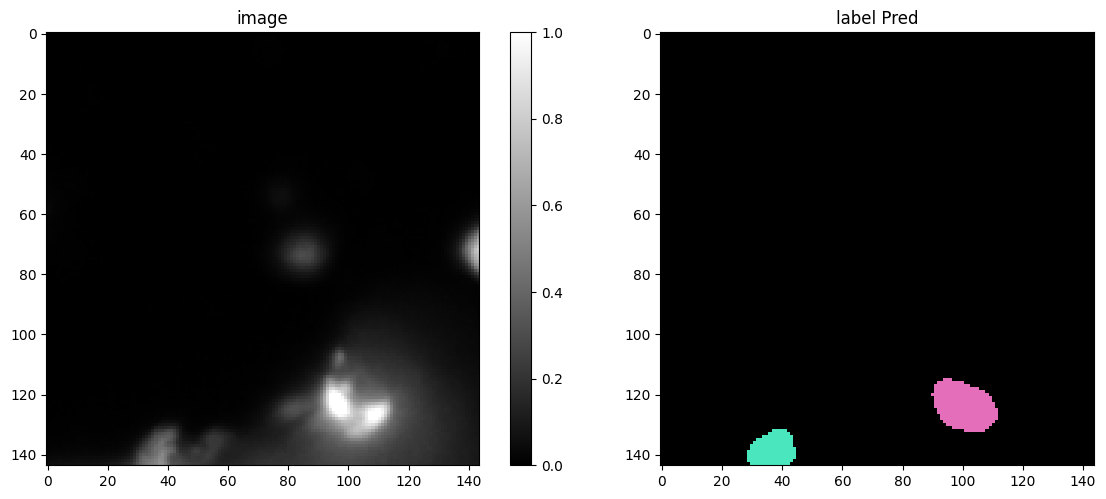

In [32]:
#PLot original labels and predcitions
plot_img_label(X_val[2],Y_val[2], lbl_title="label GT")
plot_img_label(X_val[2],Y_val_pred[2], lbl_title="label Pred")


taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val[0], Y_val_pred[0], thresh=t, show_progress=False) for t in tqdm(taus)]

stats[taus.index(0.5)]

In [33]:
stats

[DatasetMatching(criterion='iou', thresh=0.1, fp=98, tp=106, fn=104, precision=0.5196078431372549, recall=0.5047619047619047, accuracy=0.34415584415584416, f1=0.5120772946859904, n_true=210, n_pred=204, mean_true_score=0.297007579320953, mean_matched_score=0.5884112420509446, panoptic_quality=0.30131203699227116, by_image=False),
 DatasetMatching(criterion='iou', thresh=0.2, fp=98, tp=106, fn=104, precision=0.5196078431372549, recall=0.5047619047619047, accuracy=0.34415584415584416, f1=0.5120772946859904, n_true=210, n_pred=204, mean_true_score=0.297007579320953, mean_matched_score=0.5884112420509446, panoptic_quality=0.30131203699227116, by_image=False),
 DatasetMatching(criterion='iou', thresh=0.3, fp=107, tp=97, fn=113, precision=0.47549019607843135, recall=0.46190476190476193, accuracy=0.305993690851735, f1=0.46859903381642515, n_true=210, n_pred=204, mean_true_score=0.28520508862677074, mean_matched_score=0.6174543155837304, panoptic_quality=0.28933849570831816, by_image=False),
 

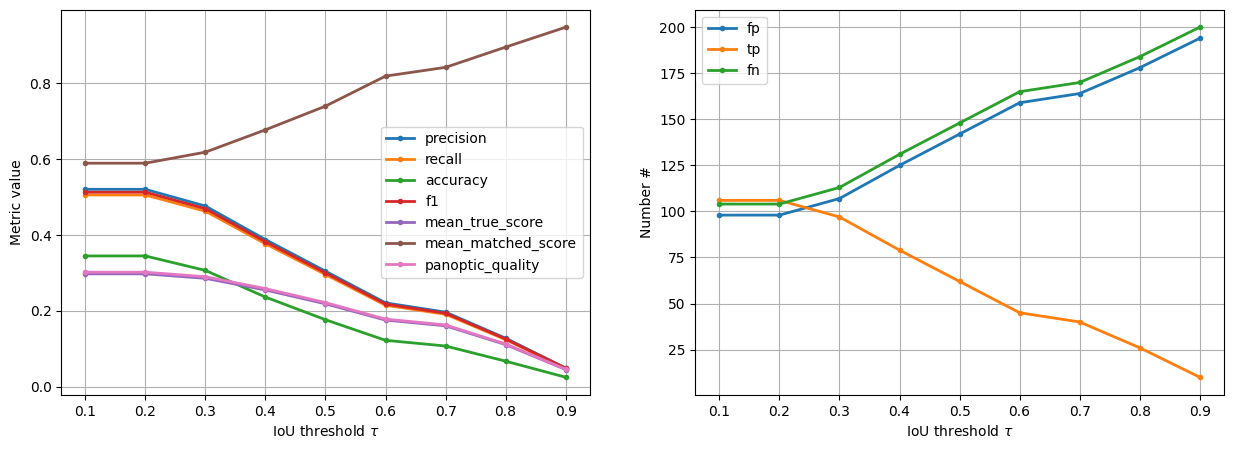

In [34]:
#Plot key metrics
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

